In [1]:
# !pip install wordcloud
# !pip install gensim
# !pip install spacy

In [2]:
# references
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
# https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [2]:
# Importing modules
import pandas as pd
import os

# LDA Model
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
from gensim.models import CoherenceModel
import spacy

# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

#plotting libraries!
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import the wordcloud library
from wordcloud import WordCloud

# Visualize the topics
import pyLDAvis.gensim
import pickle 
import pyLDAvis


In [7]:
# Read data into questions
df = pd.read_csv('../data/finance_questions.csv', encoding='utf-8')
df = df[['question']]
df.head()

,question
0,What is considered a business expense on a bus...
1,Claiming business expenses for a business with...
2,Transferring money from One business checking ...
3,Having a separate bank account for business/in...
4,Business Expense - Car Insurance Deductible Fo...


In [8]:
df.shape

(6648, 1)

## Data Cleaning


#### Text Pre-Processing
We have use gen-sim simple preprocess util to 
(1) Tokenize the textual data.
(2) convert to list of lowercase tokens
(3) deacc = True removes punctuation


In [11]:
import gensim 

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations and special characters

data_words = list(sent_to_words(df['question']))

In [12]:
print(data_words[:3])

[['what', 'is', 'considered', 'business', 'expense', 'on', 'business', 'trip'], ['claiming', 'business', 'expenses', 'for', 'business', 'with', 'no', 'income'], ['transferring', 'money', 'from', 'one', 'business', 'checking', 'to', 'another', 'business', 'checking']]


## Removal of stopwords

In [13]:
stop_words = stopwords.words('english')
# stop_words.extend(['sexual', 'harassment','harassed' 'women', 'violence', 'rape', 'raping', 'raped', 'aimforzerosg', '16dayssg','singapore', 'metoo', 'monicabaey', 'assault', 'misconduct', 'violence', 'voyeurism', 'go', 'take', 'make', 'case', 'voyeuristic' ])
# print(stop_words)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


## Phrase Modelling for Bi-grams

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

## Lemmatization

In [15]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['consider', 'business', 'expense', 'business', 'trip']]


In [19]:
#picked up bigrams eg self-employed, interest_rates
print(data_words_bigrams)

[['considered', 'business', 'expense', 'business', 'trip'], ['claiming', 'business', 'expenses', 'business', 'income'], ['transferring', 'money', 'one', 'business', 'checking', 'another', 'business', 'checking'], ['separate', 'bank', 'account', 'business', 'investing', 'business', 'account'], ['business', 'expense', 'car', 'insurance', 'deductible', 'accident', 'occurred', 'business', 'trip'], ['starting', 'new', 'online', 'business'], ['business', 'day', 'due', 'date', 'bills'], ['new', 'business', 'owner', 'taxes', 'work', 'business', 'vs', 'individual'], ['deposit', 'cheque', 'issued', 'associate', 'business', 'business', 'account'], ['hobby', 'vs', 'business'], ['personal', 'checks', 'instead', 'business', 'ones'], ['tax', 'code', 'call', 'small', 'business', 'owners', 'count', 'business', 'purchases', 'personal', 'income'], ['register', 'uk', 'business', 'without', 'providing', 'business', 'address'], ['business', 'fundamentals'], ['send', 'money', 'order', 'usps', 'business'], ['

# Exploratory Data Analysis

## Creating word cloud

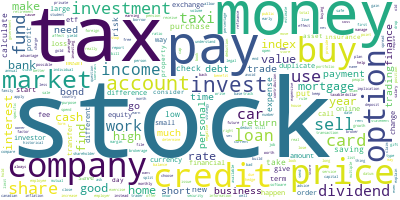

In [20]:
# Import the wordcloud library
from wordcloud import WordCloud
import itertools

# Join the different processed titles together
list_of_words = list(itertools.chain.from_iterable(data_lemmatized))
long_string = ','.join(word for word in list_of_words)
long_string

# # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', collocations = False,  random_state=1)

# # Generate a word cloud
wordcloud.generate(long_string)

# # Visualize the word cloud
wordcloud.to_image()

## Data Transformation: Corpus and Dictionary
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.

Ref: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
# id2word.filter_extremes(no_below=2, no_above=0.9)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])
# print(id2word[:10])

[[(0, 2), (1, 1), (2, 1), (3, 1)], [(0, 2), (2, 1), (4, 1), (5, 1)], [(0, 2), (6, 1), (7, 1), (8, 1), (9, 1)], [(0, 2), (10, 2), (11, 1), (12, 1), (13, 1)], [(0, 2), (3, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)], [(0, 1), (19, 1), (20, 1), (21, 1)], [(0, 1), (22, 1), (23, 1), (24, 1), (25, 1)], [(0, 2), (19, 1), (26, 1), (27, 1), (28, 1), (29, 1)], [(0, 2), (10, 1), (30, 1), (31, 1)], [(0, 1)]]


## Base Model

In [22]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=0,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [23]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.083*"use" + 0.069*"credit" + 0.044*"card" + 0.024*"large" + 0.017*"pay" + '
  '0.016*"amount" + 0.016*"brokerage" + 0.016*"public" + 0.016*"account" + '
  '0.015*"issue"'),
 (1,
  '0.047*"income" + 0.041*"taxis" + 0.039*"trade" + 0.034*"exchange" + '
  '0.028*"equity" + 0.026*"tax" + 0.024*"fee" + 0.022*"high" + 0.021*"pay" + '
  '0.018*"question"'),
 (2,
  '0.099*"invest" + 0.086*"money" + 0.045*"short" + 0.036*"account" + '
  '0.034*"go" + 0.028*"interest" + 0.024*"term" + 0.024*"save" + 0.023*"start" '
  '+ 0.020*"make"'),
 (3,
  '0.035*"pay" + 0.035*"saving" + 0.033*"happen" + 0.033*"loan" + 0.029*"cash" '
  '+ 0.027*"debt" + 0.022*"future" + 0.017*"student" + 0.017*"position" + '
  '0.016*"tax"'),
 (4,
  '0.057*"year" + 0.049*"tax" + 0.043*"much" + 0.034*"change" + 0.027*"home" + '
  '0.026*"loss" + 0.025*"way" + 0.022*"return" + 0.022*"risk" + '
  '0.019*"capital"'),
 (5,
  '0.133*"stock" + 0.066*"price" + 0.048*"market" + 0.047*"share" + '
  '0.047*"company" + 0.045*"o

In [24]:
# Evaluate base model- Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4198928275063098


## Hyperparameter Tuning

In [30]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=0,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [31]:
#iterate over possible number of topics
topic_param = [5,10,15,20,25,30,35,40,45,50,55,60]
coherence_score = []

for k in topic_param:
    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(cv)

param_tuning_coherence = pd.DataFrame()
param_tuning_coherence["topic_param"] = topic_param
param_tuning_coherence['coherence_score'] = coherence_score
param_tuning_coherence

,topic_param,coherence_score
0,5,0.399460
1,10,0.407649
2,15,0.409448
3,20,0.413622
4,25,0.416331
5,30,0.410657
6,35,0.413161
7,40,0.388411
8,45,0.433913
9,50,0.418667


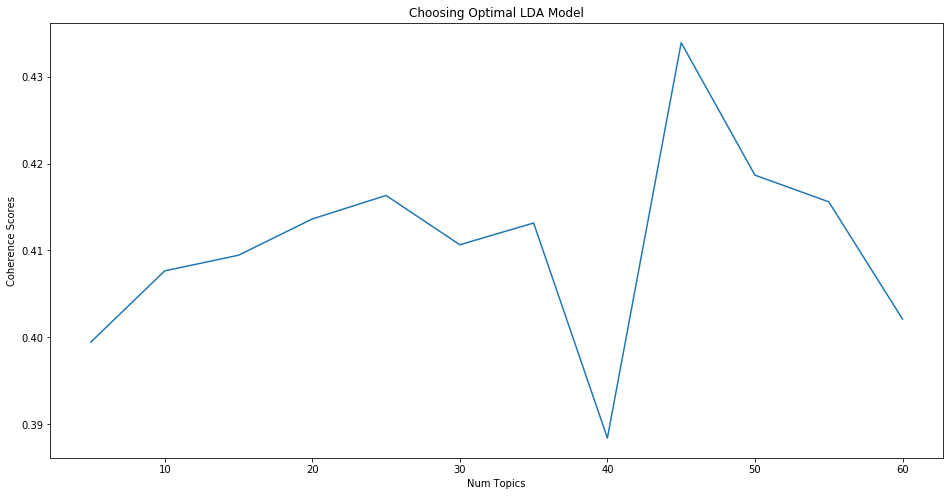

In [32]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, param_tuning_coherence['coherence_score'])

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

## Final Model

In [41]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=35, 
                                           random_state=0,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [42]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(18,
  '0.067*"tax" + 0.027*"income" + 0.020*"return" + 0.014*"strategy" + '
  '0.013*"plan" + 0.011*"loss" + 0.011*"payment" + 0.010*"employee" + '
  '0.008*"form" + 0.007*"implication"'),
 (19,
  '0.073*"fund" + 0.040*"index" + 0.017*"etfs" + 0.014*"mutual" + '
  '0.013*"datum" + 0.009*"invest" + 0.008*"really" + 0.008*"expense" + '
  '0.005*"ratio" + 0.004*"emergency"'),
 (26,
  '0.092*"option" + 0.037*"good" + 0.030*"find" + 0.011*"exercise" + '
  '0.011*"rule" + 0.008*"help" + 0.006*"understand" + 0.004*"expire" + '
  '0.003*"long" + 0.003*"early"'),
 (14,
  '0.075*"investment" + 0.027*"time" + 0.016*"financial" + 0.015*"portfolio" + '
  '0.013*"property" + 0.010*"first" + 0.004*"real" + 0.004*"advice" + '
  '0.004*"diversify" + 0.003*"trust"'),
 (0,
  '0.015*"personal" + 0.012*"month" + 0.012*"pension" + 0.009*"trader" + '
  '0.007*"finance" + 0.006*"large" + 0.002*"retail" + 0.001*"add" + '
  '0.001*"pool" + 0.001*"management"'),
 (12,
  '0.026*"duplicate" + 0.018*"currency" + 

## Document Topic Matrix

In [76]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))   
  
  

In [77]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(df)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
df['Doc'] = doc_num
df['Topic'] = topic_num
df['Probability'] = prob
df.to_csv("doc_topic_matrix.csv", index=False)

In [78]:
df

,question,Doc,Topic,Probability
0,What is considered a business expense on a bus...,0,31,0.510574
1,Claiming business expenses for a business with...,1,18,0.936444
2,Transferring money from One business checking ...,2,22,0.946453
3,Having a separate bank account for business/in...,3,22,0.953740
4,Business Expense - Car Insurance Deductible Fo...,4,27,0.959266
...,...,...,...,...
6643,Is real (physical) money traded during online ...,6643,22,0.606293
6644,"Pensions, annuities, and “retirement”",6644,32,0.533422
6645,What does it mean to a life insurance policy h...,6645,27,0.418387
6646,Can capital loss in traditional IRA and Roth I...,6646,18,0.559324


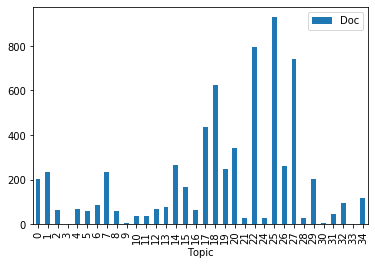

In [79]:
#Number of docs per topic
df_visual = df[['Topic','Doc']].groupby('Topic').agg('count')
df_visual
df_visual.plot.bar()

## Visualize Topics

In [43]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', sort_topics=False)
LDAvis_prepared

C:\Users\Xuesi\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.015510 -0.011815       1        1   1.380523
1      0.023245  0.086499       2        1   3.201667
2      0.028953  0.008859       3        1   1.239844
3     -0.003566  0.003789       4        1   0.197135
4      0.022863  0.032851       5        1   1.296089
5     -0.021191  0.025693       6        1   1.434171
6     -0.030389  0.006470       7        1   1.497611
7     -0.067887  0.035602       8        1   3.450572
8      0.014866  0.002968       9        1   1.197713
9     -0.003810  0.003600      10        1   0.254436
10     0.006138  0.001453      11        1   0.855032
11    -0.003223  0.012440      12        1   0.810345
12     0.012944  0.017243      13        1   1.258771
13    -0.021804 -0.003772      14        1   1.443286
14     0.055513 -0.051778      15        1   3.893576
15    -0.023111 -0.060548      16        1   2.768134
16    -0.008902 -0.012717      17        1   1.008813
17     0.092127 -0.092969      18        1   6.485257
18    -0.015466  0.130377      19        1   8.557261
19     0.014614 -0.089503      20        1   3.561219
20    -0.075648  0.004985      21        1   4.998548
21    -0.002345  0.000320      22        1   0.547940
22     0.135742  0.072690      23        1  10.795019
23    -0.003545  0.003769      24        1   0.183119
24    -0.000322 -0.001089      25        1   0.568543
25    -0.081204 -0.197711      26        1  12.967640
26    -0.075575  0.078735      27        1   3.855795
27     0.146759  0.001563      28        1  11.185299
28    -0.009832  0.003024      29        1   0.669679
29    -0.086367 -0.034088      30        1   3.433754
30    -0.004023  0.004398      31        1   0.264234
31    -0.002564 -0.010012      32        1   0.910249
32    -0.026615 -0.021203      33        1   1.668364
33    -0.003511  0.003781      34        1   0.200077
34     0.001621  0.046099      35        1   1.960288, topic_info=     Category        Freq        Term       Total  loglift  logprob
367   Default  651.000000       stock  651.000000  30.0000  30.0000
202   Default  134.000000       price  134.000000  29.0000  29.0000
39    Default  196.000000         tax  196.000000  28.0000  28.0000
8     Default  224.000000       money  224.000000  27.0000  27.0000
394   Default  125.000000      option  125.000000  26.0000  26.0000
...       ...         ...         ...         ...      ...      ...
3058  Topic35    0.549822  cost_basis   13.195532   0.7540  -7.0805
1932  Topic35    0.584447      buying   18.516932   0.4763  -7.0195
1138  Topic35    0.538644    pros_con   14.652377   0.6288  -7.1011
989   Topic35    0.489680     convert   11.915071   0.7403  -7.1964
968   Topic35    0.491809     compare   16.645082   0.4103  -7.1920

[1470 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2570     23  0.159179   absolute
2570     28  0.159179   absolute
2465     23  0.158766        abt
2465     28  0.158766        abt
3246     23  0.159152  abundance
...     ...       ...        ...
247      23  0.353476      young
247      26  0.088369      young
247      28  0.088369      young
1106     23  0.151542    youtube
1106     28  0.151542    youtube

[4225 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

## Assign topic to user query

In [80]:
#Given a question, find the closest context

def assign_topic(test_data):
    test_words = list(sent_to_words([test_data]))
    test_words = remove_stopwords(test_words)
    test_words_bigrams = make_bigrams(test_words)
    test_data_lemmatized = lemmatization(test_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    test_id2word = corpora.Dictionary(test_data_lemmatized)

    # Create Corpus
    test_texts = test_data_lemmatized

    # Term Document Frequency
    test_corpus = [id2word.doc2bow(text) for text in test_texts]

    new_topics = lda_model[test_corpus]
    
    output_topics = []
    for topic in new_topics:
          output_topics += topic
    return output_topics

In [121]:
df

,question,Doc,Topic,Probability
0,What is considered a business expense on a bus...,0,31,0.510574
1,Claiming business expenses for a business with...,1,18,0.936444
2,Transferring money from One business checking ...,2,22,0.946453
3,Having a separate bank account for business/in...,3,22,0.953740
4,Business Expense - Car Insurance Deductible Fo...,4,27,0.959266
...,...,...,...,...
6643,Is real (physical) money traded during online ...,6643,22,0.606293
6644,"Pensions, annuities, and “retirement”",6644,32,0.533422
6645,What does it mean to a life insurance policy h...,6645,27,0.418387
6646,Can capital loss in traditional IRA and Roth I...,6646,18,0.559324


In [118]:
similar_rows = df.loc[df['Topic'] == 15]
p = 0.4
# similar_rows
recommended = similar_rows.loc[(similar_rows['Probability'] > p - 0.1) & (similar_rows['Probability'] <= p+0.1)]
a = recommended['question'].iloc[:3]
a.values.tolist()

['30% share in business',
 'Taxation of shares',
 'How to categorize shared income?']

In [119]:
def recommend_qns(df, lda_output, threshold):
    for x, y in lda_output:
        sorted_by_second = sorted(lda_output, key=lambda tup: tup[1], reverse=True)
        top_topic = sorted_by_second[0][0] #find topic that has highest probability
        top_prob = sorted_by_second[0][1]
        simiar_rows = df.loc[df['Topic'] == top_topic]
        recommended = similar_rows.loc[(similar_rows['Probability'] > top_prob - threshold) & (similar_rows['Probability'] <= top_prob + threshold)] # user set threshold
        qns = recommended['question'].iloc[:3].values.tolist()
        return qns

## Qualitative Evaluation

Here, we evaluate if the assigned topic for the user query matches the assigned topic for the context. Out of 4 test data, only one was correct.

### Evaluation #1

In [146]:
# The correct context was found in Topic 20
test_data = "How do insurance funds work?"
lda_output = assign_topic(test_data)
print(lda_output)


[(19, 0.30723324), (22, 0.30206978), (27, 0.2951712)]


In [147]:
recommend_qns(df, lda_output, 0.1)

['Good book-keeping software?',
 'What happens when PayPal overdrafts a checking account (with an ample backup funding source available)?',
 'How can I determine if a debt consolidation offer is real or a scam?']

### Evaluation #2

In [148]:
# the actual context was NOT found in topic 10!
test_data = "Advice on replacing my savings account"
output = assign_topic(test_data)
print(output)

[(2, 0.57293445), (22, 0.32854798)]


In [149]:
recommend_qns(df, output, 0.1)

['Are there any issues with registering an LLC in a foreign state?',
 'What is a good open source Windows finance software',
 'Are marijuana based investments promising, or just another scam?']

### Deploying Model

In [44]:
import joblib
filename = "LDAmodel_v1.sav"
joblib.dump(lda_model, filename)

['LDAmodel_v1.sav']

In [38]:
#load model
model = joblib.load("LDAmodel.sav")
def assign_topic(test_data):
    test_words = list(sent_to_words([test_data]))
    test_words = remove_stopwords(test_words)
    test_words_bigrams = make_bigrams(test_words)
    test_data_lemmatized = lemmatization(test_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    test_id2word = corpora.Dictionary(test_data_lemmatized)

    # Create Corpus
    test_texts = test_data_lemmatized

    # Term Document Frequency
    test_corpus = [id2word.doc2bow(text) for text in test_texts]

    new_topics = model[test_corpus]
    
    output_topics = []
    for topic in new_topics:
          output_topics += topic
    return output_topics